In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import re

import ectools as ec


In [2]:
os.getcwd()

print(os.listdir('data/'))

['240902_20_MCL13_cspWE_CV2_750C_CO2.DTA', '240902_12_MCL13_cswWE_CV2_750C_CO2.DTA', '240902_14a_OCP.DTA', '240902_21a_OCP.DTA', '240902_15a_OCP.DTA', '240902_12a_OCP.DTA', '240902_01c_MCL13_cswWE_CV20_initial_test.DTA', '240902_01b_MCL13_cswWE_CV20_initial_test.DTA', '240902_17a_OCP.DTA', '240902_05a_OCP.DTA', '240902_23a_OCP.DTA', '240902_09_MCL13_cswWE_CV2_750C_CO2.DTA', '240902_01d_MCL13_cswWE_CV20_initial_test.DTA', '240902_15_MCL13_cswWE_CV2_750C_CO2_post.DTA', '240902_19a_OCP.DTA', '240902_01_MCL13_cswWE_CV20_initial_test.DTA', '240902_11a_OCP.DTA', '240902_06a_OCP.DTA', '240902_24_MCL13_cspWE_CV2_750C_CO2.DTA', '240902_04_MCL13_cswWE_CV2_750C_CO2.DTA', '240902_05_MCL13_cswWE_CV2_750C_CO2.DTA', '240902_18a_OCP.DTA', '240902_16_MCL13_cswWE_CV10_750C_CO2.DTA', '240902_22_MCL13_cspWE_CV1_750C_CO2.DTA', '240902_14_MCL13_cswWE_CV1_750C_CO2.DTA', '240902_10_MCL13_cswWE_CV2_750C_CO2.DTA', '240902_03a_OCP.DTA', '240902_21_MCL13_cspWE_CV2_750C_CO2.DTA', '240902_08a_OCP.DTA', '240902_10a_

In [3]:
current_path = os.getcwd()
data_path  = current_path + "\\data\\"

data_files = os.listdir('data')

In [4]:
imp = ec.ecImporter()
#f = imp.load_folder(data_path)
f = imp.load_folder('data')
print(f)

<class 'float'>
<class 'float'> 49.
<class 'float'> 49..
ectools.parse_file_gamry error:
'curr'
<class 'float'> 49...
ectools.parse_file_gamry error:
'curr'
<class 'float'> 49....
ectools.parse_file_gamry error:
'curr'
<class 'float'> 49.....
ectools.parse_file_gamry error:
'curr'
ectools.parse_file_gamry error:

<class 'float'> 49.......
<class 'float'> 49.
ectools.parse_file_gamry error:
'curr'
<class 'float'> 49..
ectools.parse_file_gamry error:
'curr'
<class 'float'> 49...
ectools.parse_file_gamry error:
'curr'
<class 'float'>f 49....
ectools.parse_file_gamry error:

<class 'float'>f 49......
<class 'float'>f 49.......
ectools.parse_file_gamry error:
'curr'
<class 'float'>f 49.
<class 'float'>f 49..
ectools.parse_file_gamry error:
'curr'
<class 'float'>f 49...
ectools.parse_file_gamry error:
'curr'
<class 'float'>f 49....
<class 'float'>f 49.....
<class 'float'>f 49......
<class 'float'>f 49.......
ectools.parse_file_gamry error:
'curr'
<class 'float'>f 49.
<class 'float'>f 49..
<c

AttributeError: 'ecList' object has no attribute 'log'

In [6]:

fpath = 'data/'
fname = '240902_18_MCL13_cswWE_CV50_750C_CO2.DTA'

meta_dict = {}
with open(fpath + fname) as f: # Open the file to read the first lines
    while line:=f.readline().strip():
        line = line.split('\t')
        if "TABLE" in line:
            break
        match len(line):
            case 1:
                continue
            case 2: 
                meta_dict[line[0]] = {'value': line[1]}
            case 4 | 5:
                if line[0] == 'NOTES': # handle the multi-line note field
                    meta_dict[line[0]] = {'value': ""}
                    for i in range(0,int(line[2])):
                        meta_dict[line[0]]['value'] += f.readline().strip() # this also accounts for empty lines in notes, so the while loop keeps running
                else:
                    meta_dict[line[0]] = {
                        'label': line[1],
                        'value': line[2],
                        'description': ', '.join(line[3:])
                    }
            case _:
                print('WTF?') # todo raise error
                print(line)

print(meta_dict)


{'TAG': {'value': 'CV'}, 'TITLE': {'label': 'LABEL', 'value': 'Cyclic Voltammetry', 'description': 'Test Identifier'}, 'DATE': {'label': 'LABEL', 'value': '9/3/2024', 'description': 'Date'}, 'TIME': {'label': 'LABEL', 'value': '17:42:40', 'description': 'Time'}, 'NOTES': {'value': 'cswWE - carbon steel wirecspWE - carbon steel plate 2x2 taperedCarbon steel plate counter electrodeCarbon steel wire reference electrode'}, 'PSTAT': {'label': 'PSTAT', 'value': 'REF3000-48128', 'description': 'Potentiostat'}, 'VINIT': {'label': 'POTEN', 'value': '0.00000E+000', 'description': 'T, Initial E (V)'}, 'VLIMIT1': {'label': 'POTEN', 'value': '1.70000E+000', 'description': 'F, Scan Limit 1 (V)'}, 'VLIMIT2': {'label': 'POTEN', 'value': '-1.00000E+000', 'description': 'F, Scan Limit 2 (V)'}, 'VFINAL': {'label': 'POTEN', 'value': '1.70000E+000', 'description': 'F, Final E (V)'}, 'SCANRATE': {'label': 'QUANT', 'value': '4.99999E+001', 'description': 'Scan Rate (mV/s)'}, 'STEPSIZE': {'label': 'QUANT', 'v

# Live testing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from datetime import datetime, timedelta

import ectools as ec

fpath = 'data/'
fname = '240902_18_MCL13_cswWE_CV50_750C_CO2.DTA'

imp = ec.ecImporter()
f = imp.load_file(fpath, fname)

<class 'float'>


In [3]:
f.starttime

datetime.datetime(2024, 9, 3, 17, 42, 40)

[datetime.datetime(2024, 9, 3, 17, 42, 40, 20000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 40000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 60000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 80000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 100000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 120000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 140000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 160000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 180000)
 datetime.datetime(2024, 9, 3, 17, 42, 40, 200000)]


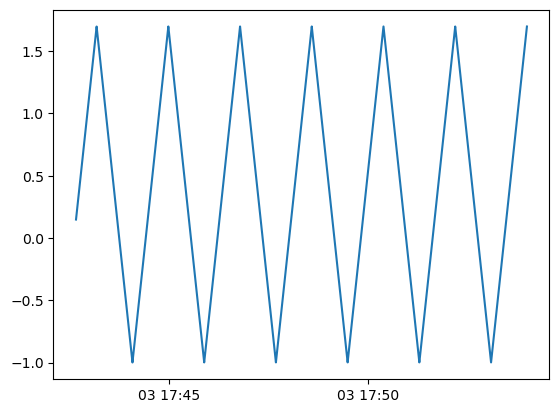

In [8]:
timedeltas = np.array([timedelta(seconds=t) for t in f.time])
        
        # Add each timedelta to the starttime to get the timestamp
timestamps = np.array([f.starttime + delta for delta in timedeltas])
print(timestamps[:10])

plt.plot(timestamps, f.pot)

In [35]:
a = np.array(f.time, dtype=timedelta)[10]

In [37]:
timedelta()

TypeError: unsupported type for timedelta days component: str

In [39]:
np.array(f.time, dtype='timedelta64[ms]')[100]

numpy.timedelta64(2,'ms')

DTypePromotionError: The DType <class 'numpy.dtypes.TimeDelta64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes.Float64DType'>)

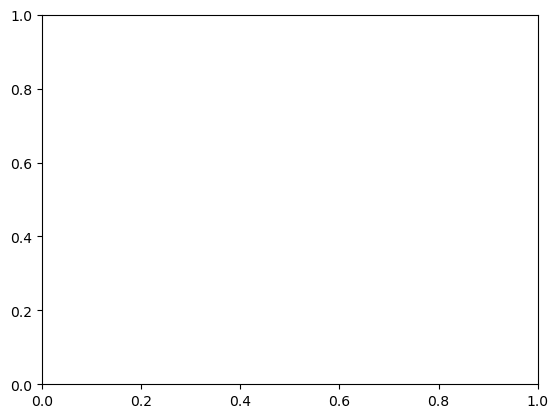

In [40]:
plt.scatter(np.array(f.time, dtype='timedelta64[ms]')[:10], f.pot[:10])
plt.show()